### Imports

In [100]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read Data to evaluate

In [101]:
eval_df = pd.read_csv("../data/evaluation/evaluation-features.csv", dtype={"url": str})
black_df = pd.read_csv("../data/evaluation/blacklist-evaluation-results.csv", dtype={"url": str})

eval_df = eval_df[["url", "label"]].copy()
black_df = black_df[["url", "label"]].copy()

eval_df["label"] = eval_df["label"].astype(int)
black_df["label"] = black_df["label"].astype(int)

In [102]:
# Check if there are URLs with different labels in the same file.
conflicts_eval = (eval_df.groupby("url")["label"].nunique() > 1).sum()
conflicts_black = (black_df.groupby("url")["label"].nunique() > 1).sum()

print("Conflict-URLs in eval_df :", conflicts_eval)
print("Conflict-URLs in black_df:", conflicts_black)


Conflict-URLs in eval_df : 0
Conflict-URLs in black_df: 0


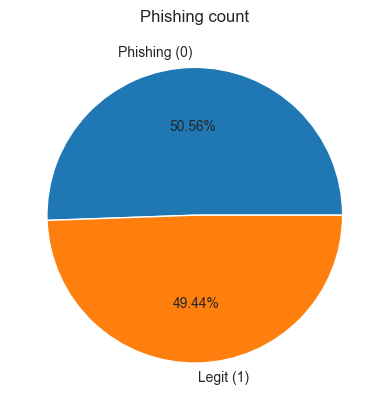

In [103]:
counts = eval_df['label'].value_counts()
counts = counts.rename(index={0: 'Phishing (0)', 1: 'Legit (1)'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Phishing count")
plt.ylabel('')
plt.show()

### Evaluate Blacklist

In [104]:
# Merge Files by URLs to calculate evaluation metrics
merged = (
    eval_df.rename(columns={"label": "true_label"})
    .merge(
        black_df.rename(columns={"label": "pred_label"}),
        on="url",
        how="inner"
    )
)

print(f"Number of blacklisted URLs: {len(black_df)}")
print(f"Number of evaluation URLs: {len(eval_df)}")
print(f"Number of matched URLs: {len(merged)}")

y_evaluation_features = merged["true_label"].to_numpy()
y_blacklist_results   = merged["pred_label"].to_numpy()

Number of blacklisted URLs: 54270
Number of evaluation URLs: 54270
Number of matched URLs: 54270


In [105]:
acc_eval_blc = metrics.accuracy_score(y_evaluation_features, y_blacklist_results)
print("Blacklist : Accuracy on evaluation Data: {:.4f}".format(acc_eval_blc))

Blacklist : Accuracy on evaluation Data: 0.5937


In [106]:
print(metrics.classification_report(y_evaluation_features, y_blacklist_results, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     1.0000    0.1965    0.3284     27439
    Legit(1)     0.5489    1.0000    0.7088     26831

    accuracy                         0.5937     54270
   macro avg     0.7745    0.5982    0.5186     54270
weighted avg     0.7770    0.5937    0.5165     54270



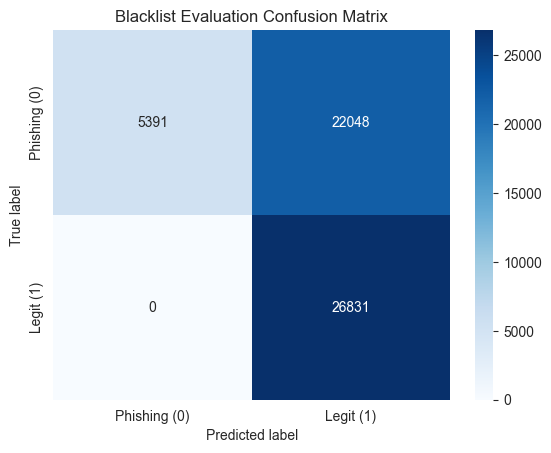

In [107]:
blacklist_conf_matrix = metrics.confusion_matrix(y_evaluation_features, y_blacklist_results)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(blacklist_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Blacklist Evaluation Confusion Matrix')
plt.show()


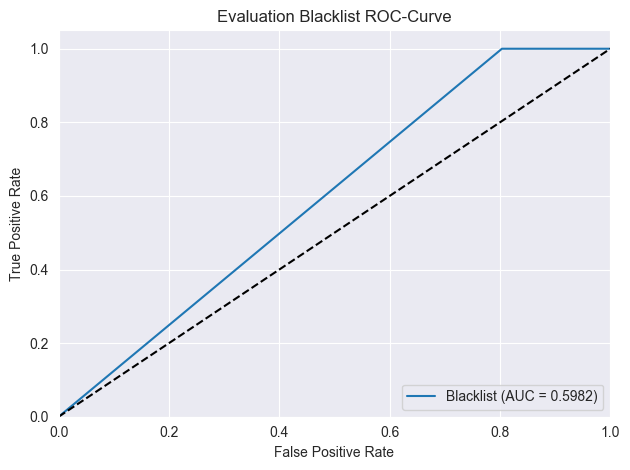

In [108]:
fpr, tpr, thresholds = metrics.roc_curve(
    y_evaluation_features,
    y_blacklist_results,
    pos_label=1
)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Blacklist (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Evaluation Blacklist ROC-Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()